# Маркетинговое исследование для приложения

Развлекательное приложение несколько месяцев несет убытки - в привлечение пользователей была вложена большая сумма денег, но это не принесло положительных результатов. 

**Цель исследования**

Нужно разобраться в причинах этой ситуации. Нам предстоит изучить:
* как люди пользуются продуктом и когда они начинают покупать
* сколько денег приносит каждый клиент и когда он окупается
* какие факторы отрицательно влияют на привлечение пользователей.

**Описание данных**

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица `orders_log_short` (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

**Ход исследования:**

1. Обзор данных и подготовка данных.
2. Формулы для расчета.
3. Исследовательский анализ.
4. Рассчеты затрат на маркетинг.
5. Оценка окупаемости рекламы.
6. Общий вывод.

## Обзор данных и подготовка данных

### Импорт библиотек

В первую очередь импортируем необходимые для исследования библиотеки.

In [1]:
import numpy as np # импорт библиотеки numpy
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
from datetime import datetime, timedelta # импорт библиотеки datetime

### Изучение данных из файла

Загрузим данные о визитах, заказах и расходах на маркетинг в переменные. Выведем таблицы на экран для ознакомления с данными.

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv') # сохранение 
orders = pd.read_csv('/datasets/orders_info_short.csv') # таблиц в
costs = pd.read_csv('/datasets/costs_info_short.csv') # переменные

display(visits.head(), orders.head(), costs.head()) # вывод первых 5 строк

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Подготовка данных

Оптимизируем данные для анализа. Приведем названия столбцов к единому стилю и убедимся, что тип данных в столбцах соответствует значениям.

In [3]:
for df in (visits, orders, costs):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    
visits.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


В таблице `visits` нужно привести данные в столбцах `session_start` и `session_end` в формат дата-время. Проверим таблицу `orders`.

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Так же нужно привести в формат дата-время данные в столбце `event_dt`. Проверим таблицу `costs`.

In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Необходимо сделать аналогичное преобразование в столбце `dt`. Также мы проверили, что в таблицах нет пропущенных значений.

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start']) # преобразование
visits['session_end'] = pd.to_datetime(visits['session_end']) # в дату и время
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942

Сейчас тип данных соответствует значениям в ячейках. Проверим таблицы на наличие явных дубликатов.

In [7]:
for name, df in zip(['visits', 'orders', 'costs'], [visits, orders, costs]):
    print(f'Дубликатов в таблице {name}: {df.duplicated().sum()}')

Дубликатов в таблице visits: 0
Дубликатов в таблице orders: 0
Дубликатов в таблице costs: 0


### Вывод

Мы привели назавния столбцов к единому стилю, поменяли тип данных в ячейках и проверили таблицы на наличие явных дубликатов.

## Функции для расчета и визуализации

### Функции для расчета

Зададим функции для создания профилей, расчёта удержания, конверсии, LTV и ROI: 
* `get_profiles()`
* `get_retention()`
* `get_conversion()`
* `get_ltv()`

Начнем с функции для создания пользовательских профилей.

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Добавим функцию для расчет удержания.

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Добавим функцию для расчета конверсии.

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Последней добавим функцию для расчета LTV и ROI.

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для визуализации

Зададим функции для визуализации метрик.

* `filter_data()`
* `plot_retention()`
* `plot_conversion()`
* `plot_ltv_roi()`

Начнем с функции для сглаживания фрейма.

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Добавим функцию для визуализации удержания.

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Добавим функцию для визуализации конверсии.

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Последней добавим функцию для визуализации LTV и ROI.

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Профили пользователей

С помощью функции построим таблицу с пользовательскими профилями.

In [16]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей

In [17]:
print('Минимальная дата привлечения пользователя:', profiles['first_ts'].min().date())
print('Максмальная дата привлечения пользователя:', profiles['first_ts'].max().date())

Минимальная дата привлечения пользователя: 2019-05-01
Максмальная дата привлечения пользователя: 2019-10-27


Период составит 6 месяцев с мая 2019 по октябрь 2019 включительно.

### География пользователей

Выясним из каких стран приходят посетители. Напишем функцию для построения графиков и посмотрим распределение пользователей по странам.

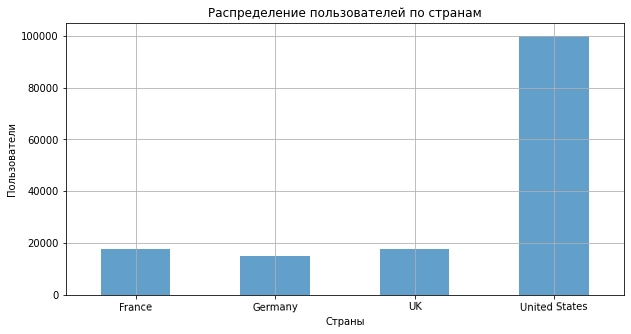

In [18]:
def bar_plot(data, index, xlabel, title, size_y, size_x): # функция для построения
    data.pivot_table(                                     # столбчатой диаграммы
        index=index, values='user_id', aggfunc='count').plot.bar(
        figsize=(size_y, size_x), rot=1, alpha=0.7, xlabel=xlabel,
        ylabel='Пользователи', legend=False, grid=True,
        title=title)
    plt.show()
    
bar_plot(profiles, 'region', 'Страны', 'Распределение пользователей по странам', 10, 5)

Лидером является США - 100000 пользователей. У Великобритании, Франции и Германии примерно в 5 раз меньше пользователей. Выясним какие страны дают больше всего платящих пользователей и построим таблицу с количеством пользователей и долей платящих из каждой страны.

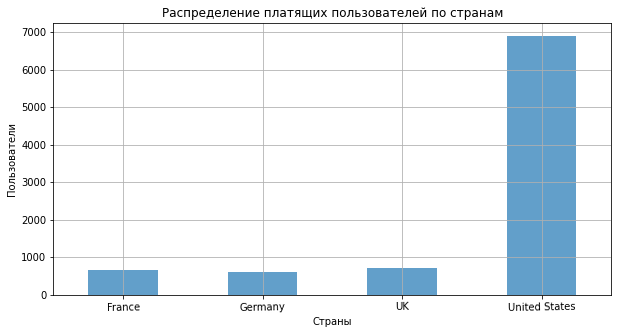

Доля платящих пользователей ко всем


,users,pay_part
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


In [19]:
bar_plot(profiles[profiles['payer'] == True], 'region', 'Страны', 'Распределение платящих пользователей по странам', 10, 5)

def pay_users(index): # функция для подсчета доли платящих пользователей
    users = profiles.pivot_table(index=index, values='user_id', aggfunc='count')
    users_pay = profiles[profiles['payer'] == True].pivot_table(index=index, values='user_id', aggfunc='count')
    users = users.merge(users_pay, on=index, how='left')
    users['pay_part'] = round(users['user_id_y'] / users['user_id_x'] * 100, 2)
    users = users.rename(columns={'user_id_x': 'users'}).drop(columns='user_id_y').sort_values(by='pay_part', ascending=False)
    print('Доля платящих пользователей ко всем')   
    display(users)
 
pay_users('region')

Больше всего платящих пользователей в США - примерно 7000. В остальных странах примерно в 10 раз меньше. Доля платщих пользователей больше всего в США - 6.9%, в остальных странах в среднем 4%.

### Устройства

Выясним какими устройствами они пользуются.

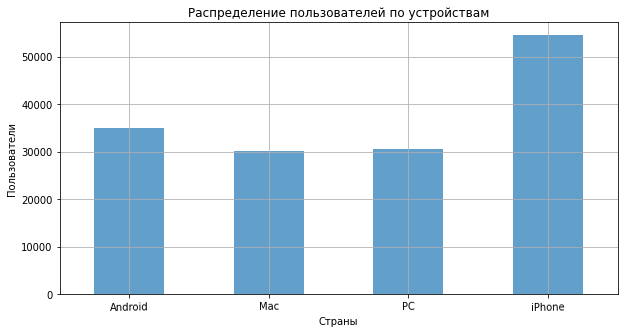

In [20]:
bar_plot(profiles, 'device', 'Страны', 'Распределение пользователей по устройствам', 10, 5)

Больше всего пользователей с iPhone - примерно 55000, на втором месте пользователи с Android - около 35000. На PC и Mac приходится примерно по 30000 пользователей. Посмотрим как обстоит ситуация с платящими пользователями. Добавим также таблицу с процентным соотношением.

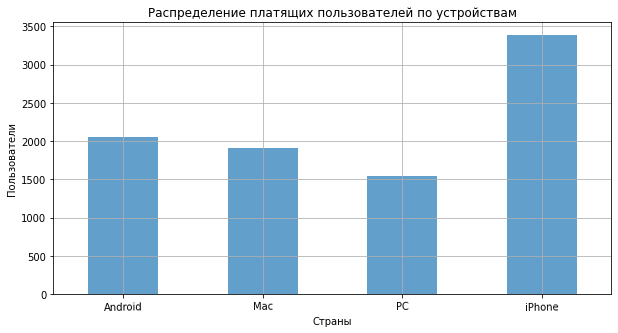

Доля платящих пользователей ко всем


,users,pay_part
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


In [21]:
bar_plot(profiles[profiles['payer'] == True], 'device', 'Страны', 'Распределение платящих пользователей по устройствам', 10, 5)
pay_users('device')

Большинство платящих пользователей с iPhone - 3400, с Android - около 2000, на Mac приходится 1900 и меньше всего на PC - 1500. Самая большая доля платящих пользователей на Mac - 6.36%, наименьшая на PC - 5.05%. На iPhone приходится 6.21%, Android - 5.85%.

### Рекламные каналы

Выясним по каким рекламным каналам шло привлечение пользователей. Посмотрим на распределение пользователей по рекламным каналам. 

и какие каналы приносят больше всего платящих пользователей.

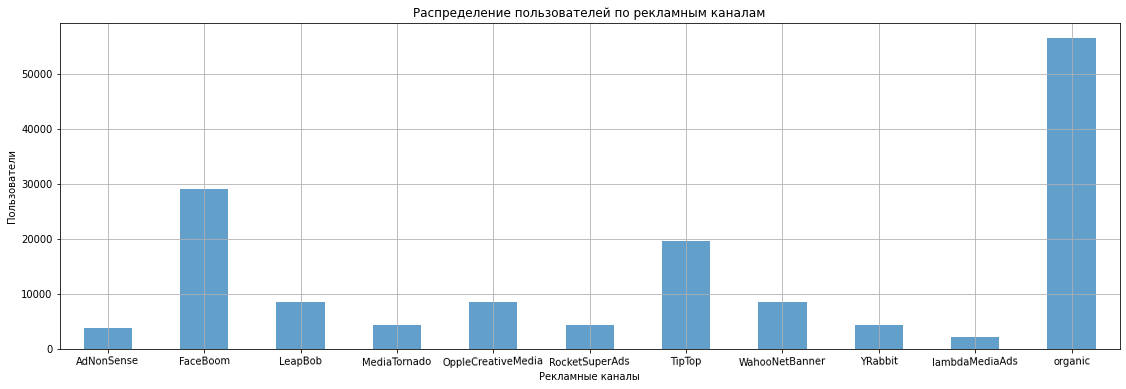

In [22]:
bar_plot(profiles, 'channel', 'Рекламные каналы', 'Распределение пользователей по рекламным каналам', 19, 6)

Большинство пользователей пришло по прямому каналу - более 55000, на втором месте канал **FaceBoom** - почти 30000, через канал **TipTop** пришло около 20000. По остальным каналам пришло менее 10000 пользователей. Посмотрим на распределение платящих пользователей.

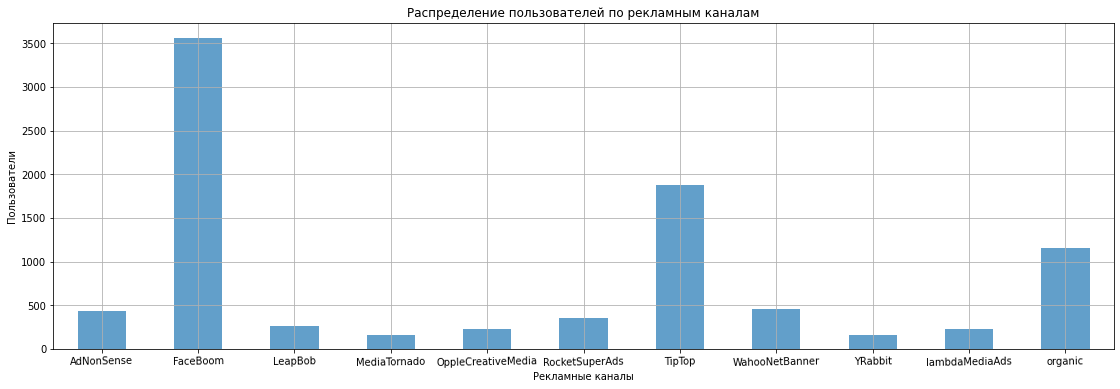

Доля платящих пользователей ко всем


,users,pay_part
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


In [23]:
bar_plot(
    profiles[profiles['payer'] == True], 'channel', 'Рекламные каналы',
    'Распределение пользователей по рекламным каналам', 19, 6)
pay_users('channel')

Больше всего платящих пользователей пришло через канал **FaceBoom** - 3500, на втором месте канал **TipTop** - 1900. По прямому каналу пришло около 1200 платящих пользователей. По остальным каналам пришло не более 500 платящих пользователей. По долям так же лидирует **FaceBoom**.

### Вывод

Мы выяснили, что большинство пользователей, в том числе платящих - из США. Чаще всего пользователи заходят в приложение c iPhone - около 40%, на остальные устройства приходится примерно по 20% пользователей. Несмотря на то, что доля платящих пользователей на Mac больше чем на iPhone: 6.36% против 6.21%, количество платящих пользователей на iPhone больше чем на Mac: 3400 против 1900. Больше всего пользователей приходит по прямому каналу, через FaceBoom и TipTop. Больше всего платящих пользователей приводит канал FaceBoom - 3500, доля - 12.2%, на втором месте TipTop: 1900 платящих пользователей и доля 9.6%. Прямой канал приводит около 1200 пользователей, но доля низкая - 2.06%. У некоторых высокая доля платящих пользователей, это каналы AdNonSense и lambdaMediaAds, но по количеству эти значения небольшие.

## Маркетинг

На данном этапе нужно посчитать расходы на маркетинг.

### Подсчет расходов

Посчитаем общую сумму расходов на маркетинг.

In [24]:
print('Общая сумма расходов на маркетинг составила', round(costs['costs'].sum(), 2))

Общая сумма расходов на маркетинг составила 105497.3


Выясним, как траты распределены по источникам. Сделаем сводную таблицу и отсортируем ее по затратам на источник по убыванию.

In [25]:
display(costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False))

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


На каналы TipTop и FaceBoom было потрачено больше всего средств, на остальные каналы - значительно меньше. 

Визуализируем изменения расходов по месяцам.

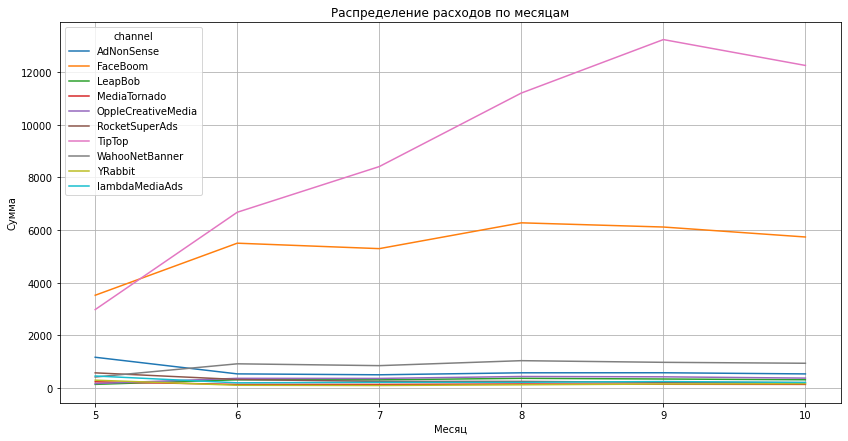

In [26]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month # получение номера месяца

costs.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True,
    figsize=(14, 7), title='Распределение расходов по месяцам', xlabel='Месяц', ylabel='Сумма')
plt.show()

Больше всего средств было вложено в канал TipTop, затраты растут до сентября, но потом снижаются. На канал FaceBoom расходы были увеличены только в мае и июле, в другие месяцы незначительно снижались. По остальным каналам изменения не существенны и расходы гораздо ниже.

### Привлечение клиента

Узнаем, сколько в среднем стоило привлечение одного пользователя. Рассчитаем средний CAC на одного пользователя для всего проекта, предварительно исключив из таблицы пользователей, которые пришли без привлечения через органический трафик.

In [27]:
profiles = profiles.query('channel != "organic"') # срез по каналу
print('Средний CAC:', round(profiles['acquisition_cost'].mean(), 2))

Средний CAC: 1.13


В среднем одно привлечение стоило 1.13. Рассчитаем средний CAC для каждого источника трафика.

In [28]:
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

Дороже всего обходятся пользователи от канала TipTop. Но на предыдущих этапах мы выяснили, что TipTop не является лидером по количеству привлеченных пользователей, в том числе платящих. Возможно, TipTop не оправдывает вложенных средств на привлечение пользователей.

### Вывод

На этапе исследовательского анализа мы выяснили, что канал FaceBoom привлекает больше всего пользователей и у канала самая высокая доля платящих пользователей, но из таблицы расходов мы видим, что на него было потрачено значительно меньше средств, чем на TipTop. Расходы на привлечение пользователей из TipTop постоянно растут и пользователи от TipTop обходятся дороже всех остальных, но TipTop не является лидером по количеству привлеченных пользователей, в том числе платящих. 

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [29]:
horizon_days = 14
observation_date = pd.to_datetime('2019-11-01', format='%Y-%m-%d')

### Проанализируем общую окупаемость рекламы

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

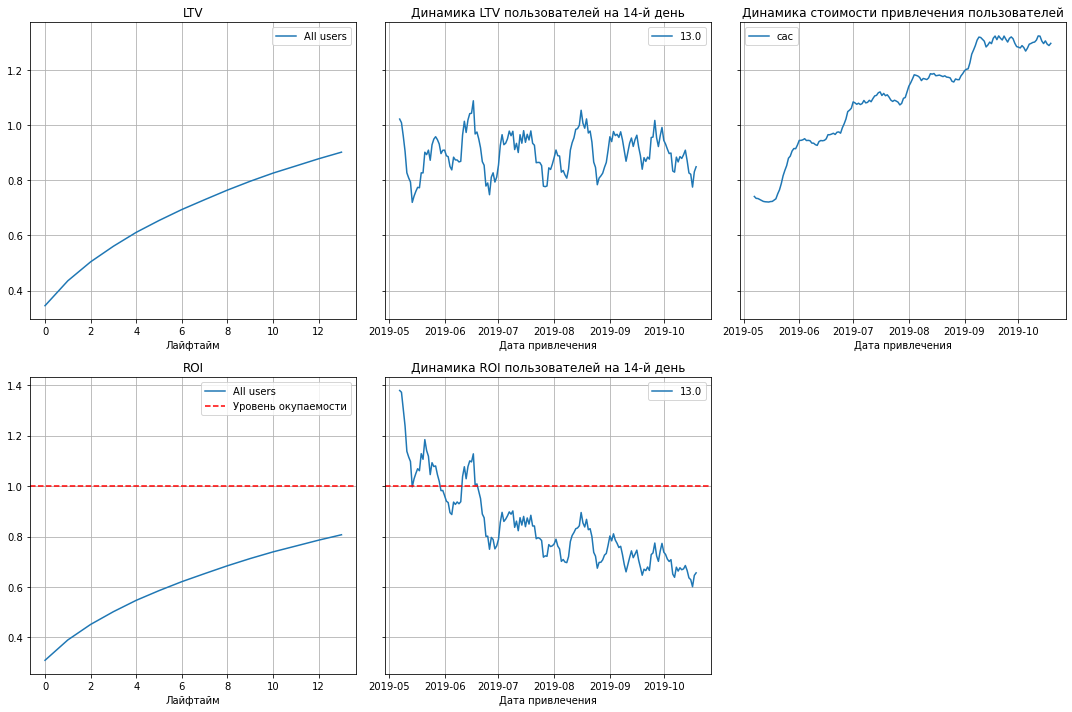

In [30]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
) # расчет ltv, roi и динамики

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) # построение графиков ltv, cac и roi

Реклама не окупается. ROI в конце второй недели чуть выше 60%. CAC растет, рекламный бюджет увеличивается. LTV достаточно стабилен.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по рекламным каналам. Так как каналов много сделаем разделение на крупные каналы и остальные. Для этого выберем самые затратные каналы, которые мы определили в пункте 4.1.

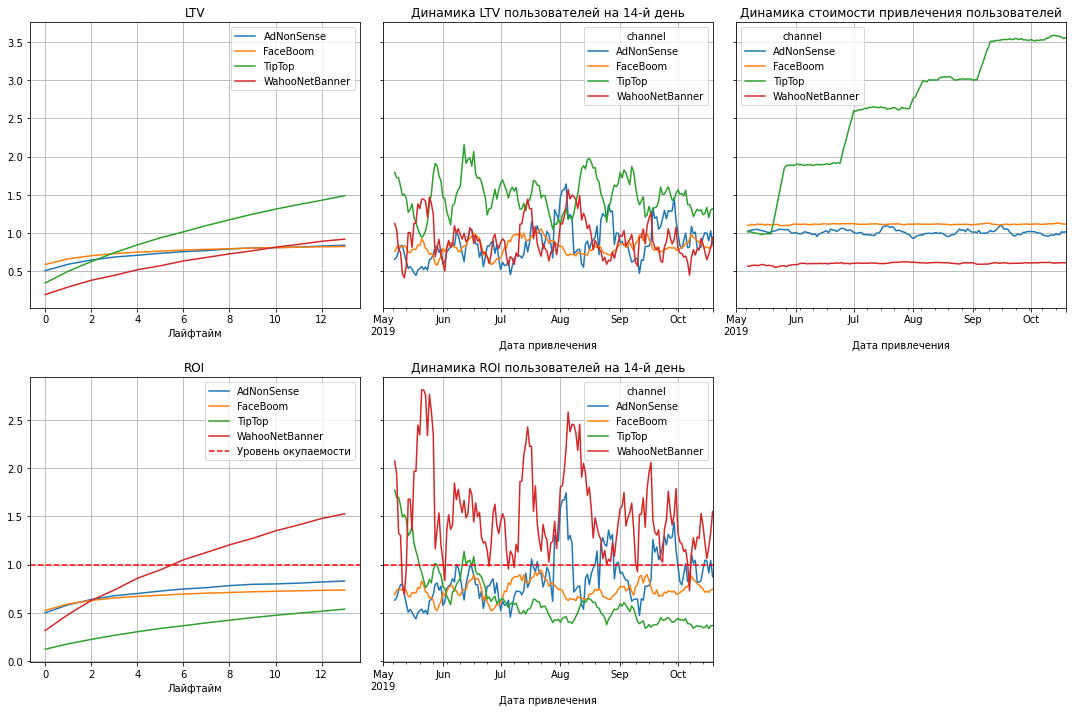

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel == ["FaceBoom", "TipTop", "WahooNetBanner", "AdNonSense"]'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'] # расчет ltv, roi и динамики по рекламным каналам
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) # построение графиков

Реклама не окупается для каналов TipTop, FaceBoom и AdNonSense, хотя в эти каналы вкладывается больше всего средств, окупается только WahooNetBanner. CAC растет только для TipTop, но результат не оправдывает этих вложений. LTV стабилен. Посмотрим остальные каналы.

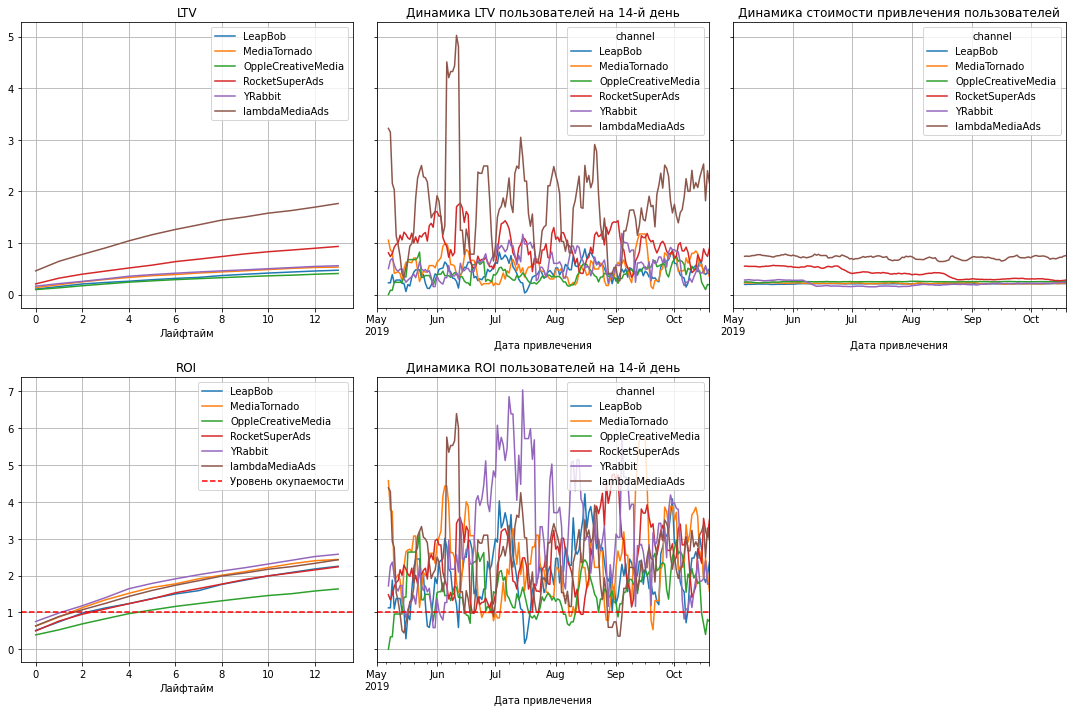

In [32]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != ["FaceBoom", "TipTop", "WahooNetBanner", "AdNonSense"]'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'] # расчет ltv, roi и динамики по рекламным каналам
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) # построение графиков

Все каналы окупаются при том, что в них вкладывается значительно меньше средств, чем в убыточные каналы FaceBoom и TipTop.

### Проанализируем окупаемость рекламы с разбивкой по странам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по странам.

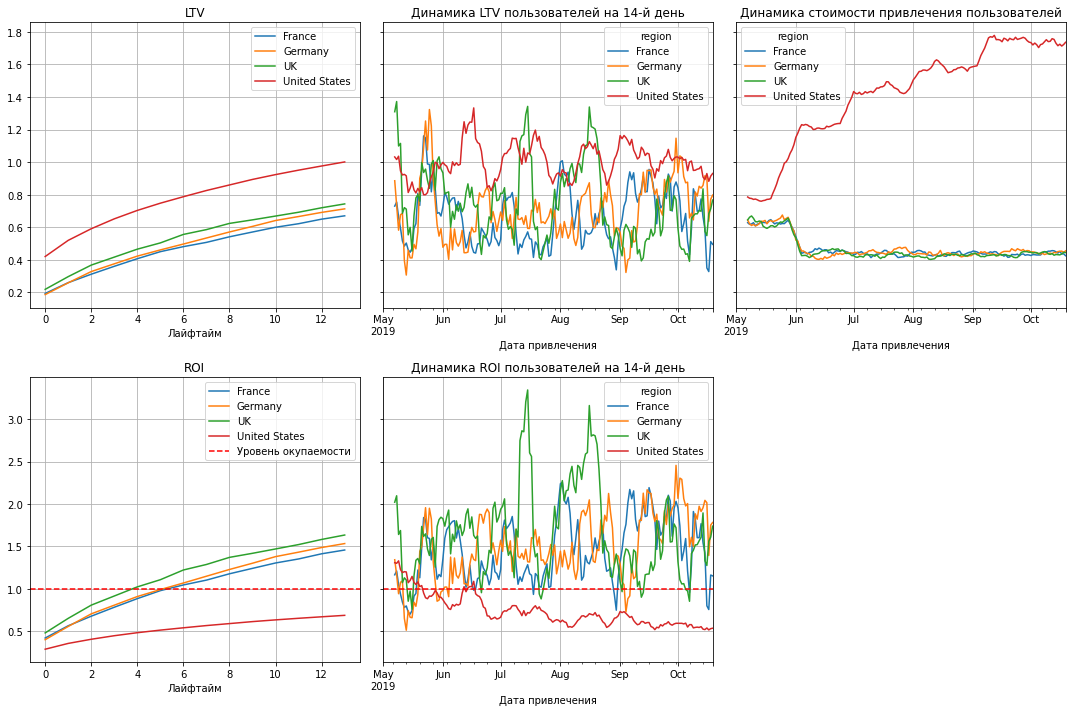

In [33]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'] # расчет ltv, roi и динамики по странам
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) # построение графиков

Реклама не окупается только в США. CAC растет так же только в США, а 2/3 всех пользователей находятся из США. LTV все еще стабилен.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по устройствам.

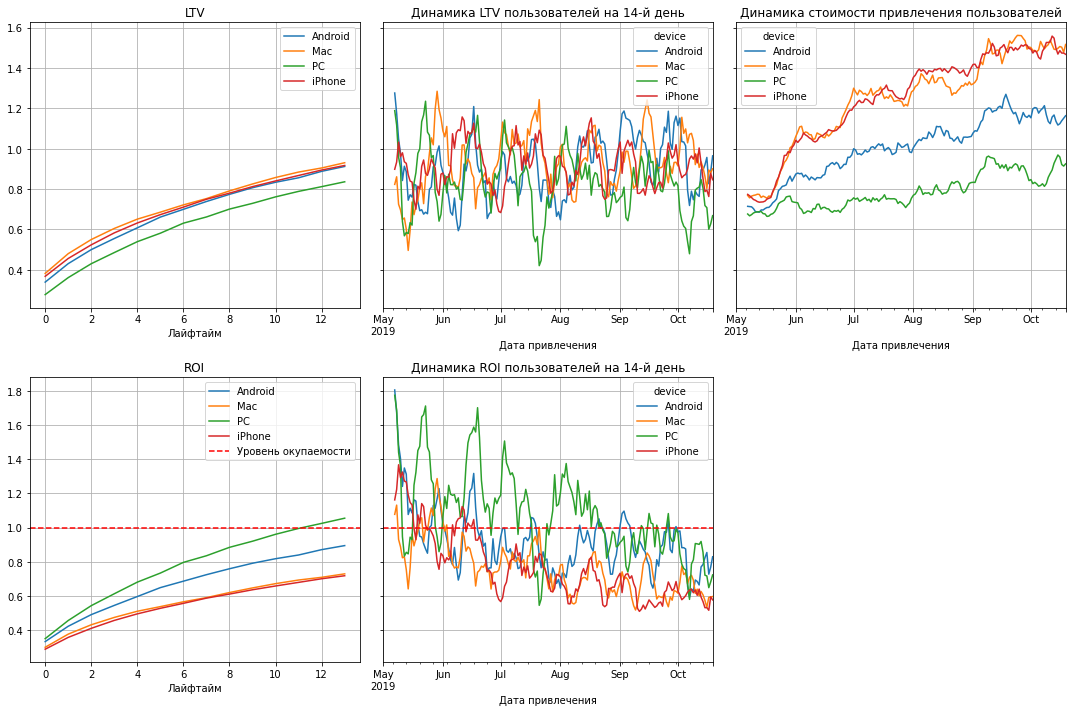

In [34]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'] # расчет ltv, roi и динамики по устройствам
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) # построение графиков

Пользователи iPhone и Mac не окупаются, но стоимость их привлечения больше остальных и растет. Пользователи PC окупаются, пользователи Android окупаются частично. LTV стабилен.

### Промежуточные выводы

На данном этапе мы обнаружили, что в целом реклама не окупается и стоимость привлечения новых пользователей растет. При детальном изучении выяснили, что такая ситуация наблюдается только в США. В остальных странах таких проблем нет, а в США находятся 2/3 от всех пользователей. В каналы привлечения TipTop и FaceBoom вкладывается больше всего средств, но реклама не окупается. Причем стоимость привлечения нового пользователя для TipTop растет, но результат не оправдывает этих вложений. Пользователей iPhone больше всего, но они не окупаются и расходы на их привлечение одни из самых высоких. В тоже время, пользователи PC окупаются и расходы на привлечение - самые низкие.

### Конверсия и удержание

Построим и изучим графики конверсии и удержания с разбивкой: 
* по устройствам
* по странам
* по рекламным каналам

Начнем с графиков по устройствам.

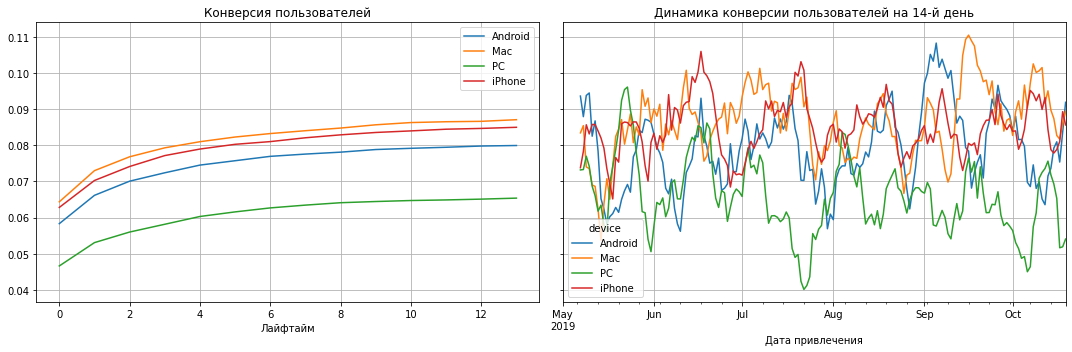

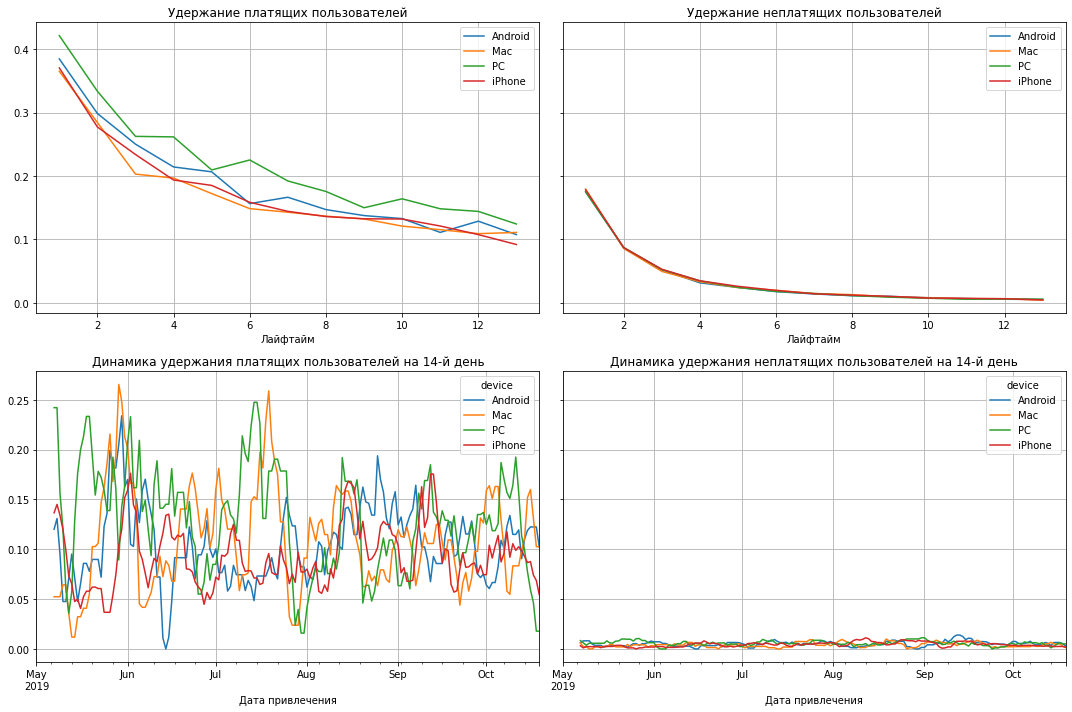

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device']
) # расчет конверсии и ее динамики по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device']
) # расчет удержания и его динамики по устройствам

plot_conversion(conversion_grouped, conversion_history, horizon_days) # построение графиков конверсии
plot_retention(retention_grouped, retention_history, horizon_days) # построение графиков удержания

Пользователи разных устройств не сильно выделяются. Можно отметить только, что пользователи PC конвертируются хуже других.

Посмотрим на графики с разбивкой по странам.

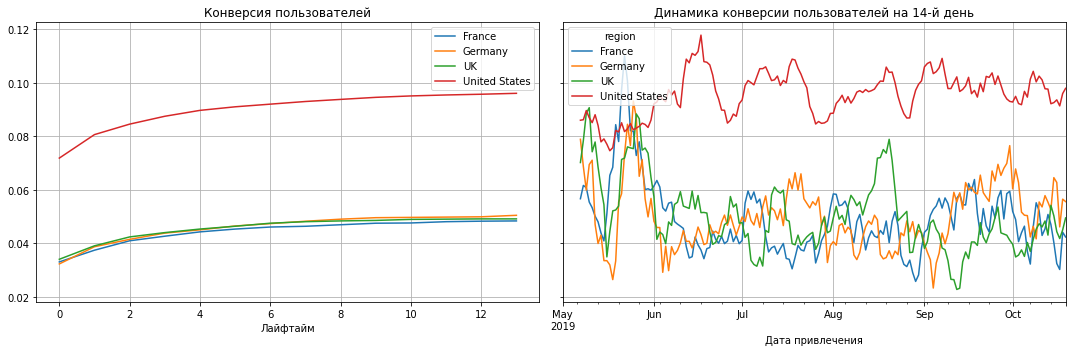

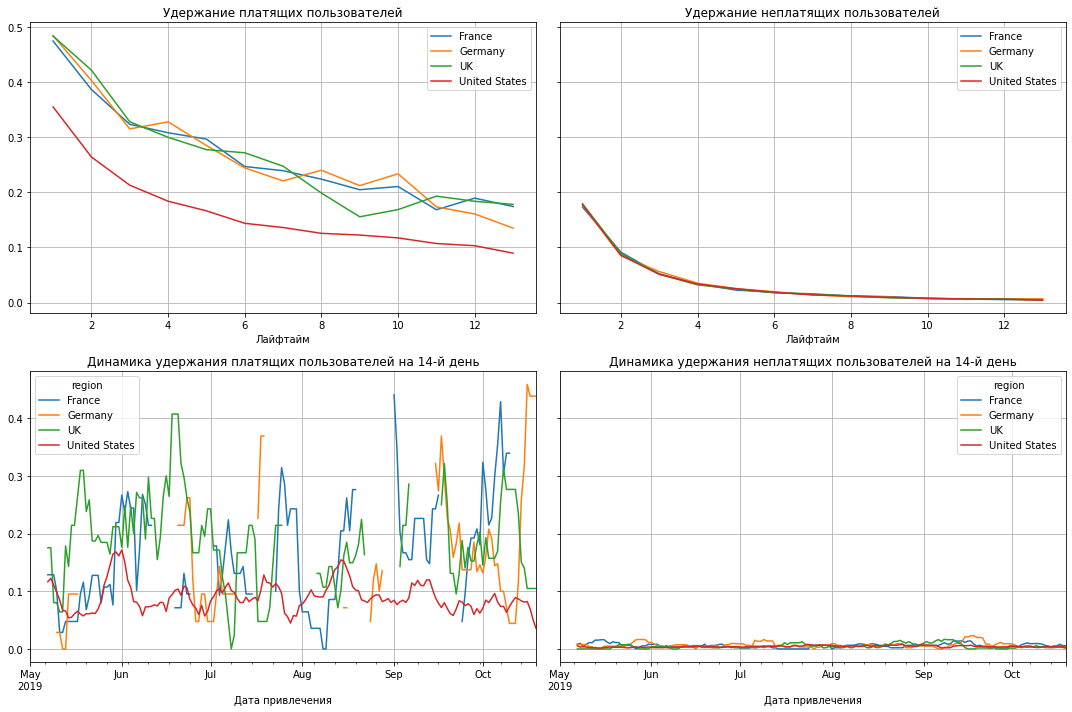

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'] # расчет конверсии и ее динамики по странам
)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'] # расчет удержания и его динамики по странам
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) # построение графиков
plot_retention(retention_grouped, retention_history, horizon_days) # построение графиков

Пользователи из США конвертируются лучше чем пользователи из других стран, но пользователи из США стабильно плохо удерживаются.

Посмотрим на графики с разбивкой по по рекламным каналам.

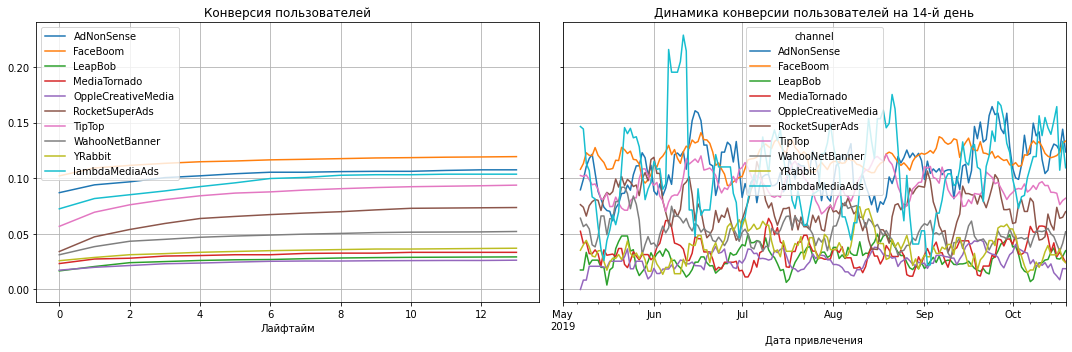

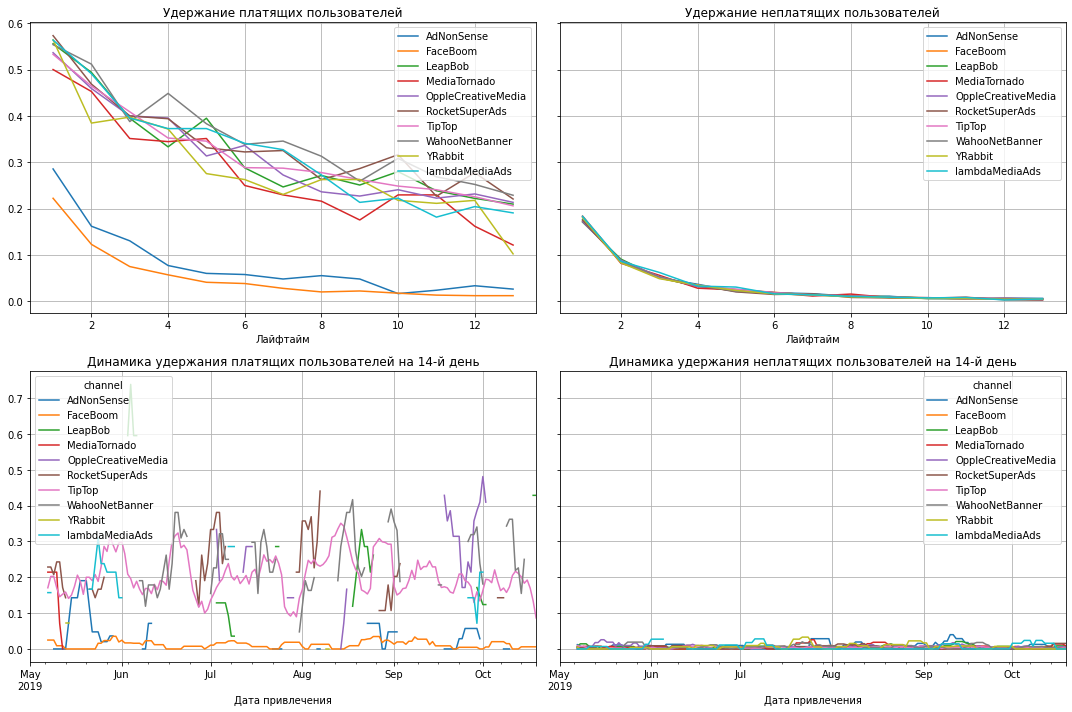

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'] # расчет конверсии и ее динамики по рекламным каналам
)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'] # расчет удержания и его динамики по устройствам по рекламным каналам
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи Faceboom и AdNonSense конвертируются лучше других, но в то же время они удерживаются хуже пользователей других каналов.

### Вывод

В целом реклама не окупается. 

Окупаемость рекламы могут снижать следующие факторы:
1. Значительная часть расходов сосредоточена на каналах TipTop, FaceBoom и AdNonSense, но реклама не окупается. Пользователи из каналов FaceBoom и AdNonSense хорошо конвертируются, но хуже всех удерживаются. Возможно это связано с неправильной коммуникацией или неподходящей настройкой целевой аудитории. Отделу маркетинга можно порекомендовать проверить рекламную кампанию в убыточных каналах, а также предожить перенаправить часть бюджета с каналов TipTop и FaceBoom на другие каналы, например lambdaMediaAds или RocketSuperAds, так как они их пользователи окупаются, хорошо конвертируются и доля платящих достаточно высокая.


2. У пользователей из США лучшая конверсия и LTV, но в тоже время эти пользователи не окупаются и стабильно плохо удерживаются. При этом самые большие расходы направлены на привлечение новых пользователей из США. Привлекается действительно много пользователей, но возможно не тех, кто заинтересован в продукте. Отделу маркетинга можно предложить перенаправить средства на рекламу из США на другие страны и проверить настройки целевой аудитории в рекламной кампании. Также провести исследование, возможно в США достигнут предел потенциальных пользователей.


3. Значительные расходы сосредоточены на привлечение пользователей iPhone и Mac. Пользователей iPhone и Mac в сумме 60% от всех пользователей, но реклама не окупается. У этих пользователей хорошие показатели конверсии, но удержание хуже, чем у пользователей других устройств. Возможно, причина в какой-нибудь технической проблеме, это нужно проверить. Отделу маркетинга можно предложить перенаправить часть средств на пользователей других устройств, например PC и Android. Также у пользователей PC самая низкая конверсия, следовательно нужно проверить, не возникает ли ошибка при первой оплате.

## Общий вывод


Причины неэффективности привлечения новых пользователей могут быть связаны с низким удержание пользователей: из США, из рекламных каналов FaceBoom и TipTop, а также владельцев устройств iPhone и Mac. Основные расходы сосредоточены на именно на перечисленных выше пользователях, но эти расходы не окупаются. В свою очередь низкое удержание может быть связано неправильно настроенной рекламной кампанией и технических проблемах. Также причина неэффективности может быть в том, что значительная часть средств ограниченно распределена на трёх рекламных каналах, одной стране и двух устройствах.

Отделу маркетинга можно дать следующие рекомендации:

1. Проверить корректность коммуникации и настройки рекламной кампании в убыточных каналах TipTop, FaceBoom и AdNonSense, а также предожить распределить часть средств с каналов TipTop и FaceBoom на другие каналы, например lambdaMediaAds или RocketSuperAds, так как они их пользователи окупаются, хорошо конвертируются и доля платящих достаточно высокая. 


2. Проверить настройки целевой аудитории рекламной кампании в США. Перенаправить часть средств на рекламу из США на другие страны, так как их пользователи хорошоокупаются.


3. Проверить, не возникает ли ошибка при первой оплате у пользователей PC. Увеличить расходы на привлечение новых пользователей устройств PC и Android.